# Data Understanding
In this section some interesting bar charts and histogram are presented

## Importing Important Libraries

In [342]:
%matplotlib inline
import numpy as np
import pandas as pd 
import scipy as sp
import sklearn as sk # data mining tools
import matplotlib.pylab as plt # plotting
import seaborn as sns # advanced plotting
import ast
import collections
import re 
pd.options.display.max_colwidth = 100
pd.options.mode.chained_assignment = None
#from pandas.tools.plotting import scatter_matrix

### Loading Data

In [343]:
main = pd.read_csv("ted_main.csv")

In this part the popularity factor is created. It is calculated as mean of min_max normalized value of number of comments, number of views and sum of ratings.

In [345]:
main['comm_sc'] = ( main['comments'] - main['comments'].min() ) / ( main['comments'].max() - main['comments'].min() )
main['views_sc'] = ( main['views'] - main['views'].min() ) / ( main['views'].max() - main['views'].min() )
main['ratings'] = main['ratings'].apply(lambda x: ast.literal_eval(x))
main['tags'] = main['tags'].apply(lambda x: ast.literal_eval(x))
main['ratings_count'] = 0

for i in range(2550):
    cnt = 0
    for rev in range(0, 14):
        cnt = cnt + main['ratings'][i][rev].get('count')
    main.loc[(i, 'ratings_count')] = cnt
    
main['ratings_nbr_sc'] = ( main['ratings_count'] - main['ratings_count'].min() ) / ( main['ratings_count'].max() - main['ratings_count'].min() )
main['popularity'] = ( main['views_sc'] + main['comm_sc'] + main['ratings_nbr_sc']) / 3
main.drop(['comm_sc','views_sc', 'ratings_nbr_sc'], axis=1, inplace = True)

In this part the funny factor is created. It is calculated as mean of min_max normalized value of number of funny in ratings and number of word "laughter" in transcripts.


In [346]:
main['funny_count'] = 0
for i in range(0,2550):
    funny_rating = 0
    for j in range(0,14):
        funny_id = main['ratings'][i][j].get('id')
        if funny_id == 7:
            funny_rating = funny_rating + main['ratings'][i][j].get('count')      
    main.loc[(i, 'funny_count')] = funny_rating
df_trans = pd.read_csv('transcripts.csv')
df_trans['laughter'] = 0
# Drop duplicates 
df_trans.drop_duplicates(keep = False,inplace = True)
# re_assign index after droping dupliacte rows 
df_trans.index = range(0,len(df_trans))

#iterate in each row and sum frequency of the word 'Laughter'
#append the value to 'loughter' col

word = 'Laughter'
for i in range(0,2461):
    count = 0
    input_tedtalk = df_trans['transcript'][i] 
    count = count + sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), input_tedtalk))
    df_trans.loc[(i,'laughter')] = count

#  frequency of funny 
main['Scaled_fcount']  = ((main['funny_count'] - main['funny_count'].min()) / (main['funny_count'].max() - main['funny_count'].min()))
# frequency of loughter 
df_trans['Scaled_laugh']  = (df_trans['laughter'] - df_trans['laughter'].min()) / (df_trans['laughter'].max() - df_trans['laughter'].min())
# Merge the two datafarmes on column = url (inner join) and return a DF
main = pd.merge(main,df_trans, on = 'url', how='outer')
main.update(main[['Scaled_fcount','Scaled_laugh','funny_count','laughter']].fillna(0))
main['funny_factor'] = (main['Scaled_fcount'] + main['Scaled_laugh'])/2
main.drop(['Scaled_fcount','Scaled_laugh', 'funny_count', 'laughter'], axis=1, inplace = True)

This is a function for showing histogram of frequency of a numerical feature.

In [182]:
def histogram(data, feature, min_val, max_val):
    feature_ = feature
    plt.figure(figsize=(7,5))
    plt.hist(main[feature_][(main[feature_] > min_val) & (main[feature_] < max_val)], bins=50)
    plt.title("Histogram of " + feature + " between " + str(min_val) + " and " + str(max_val))
    plt.ylabel('Frequency')
    plt.xlabel(feature)

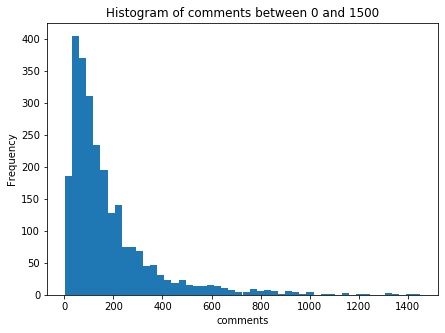

In [97]:
histogram(main, 'comments', 0, 1500)

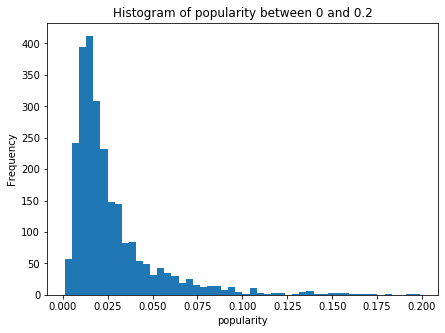

In [99]:
histogram(main, 'popularity', 0, 0.2)

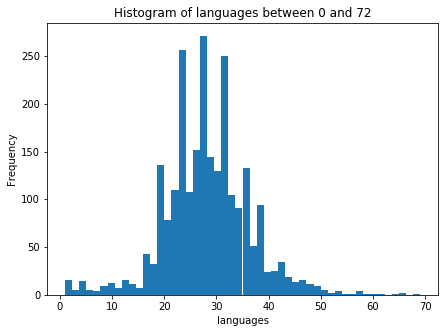

In [100]:
histogram(main, 'languages', 0, main.languages.max())

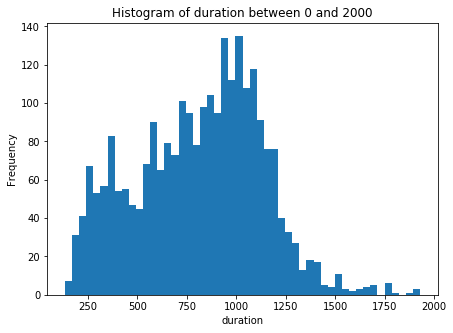

In [102]:
histogram(main, 'duration', 0, 2000)

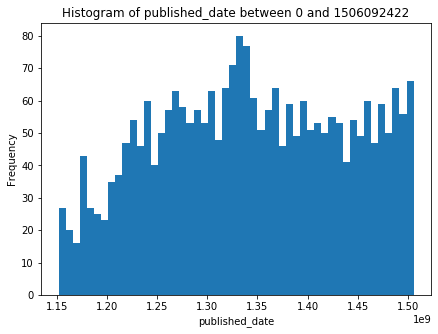

In [103]:
histogram(main, 'published_date', 0, main['published_date'].max())

This is a function for showing highest number of values based on a categorical feature

In [225]:
def show_tops(dataset, feature, limit):
    value_counts = dataset[feature].value_counts()
    #events[0:20].plot(kind='bar')
    df = value_counts.rename_axis(feature).reset_index(name='count')
    df.sort_values(by=['count'], ascending=False)[0:limit].plot(kind='bar',x = feature, figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + feature + "s")
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.xticks(rotation='vertical')
    plt.legend([])
    plt.show()

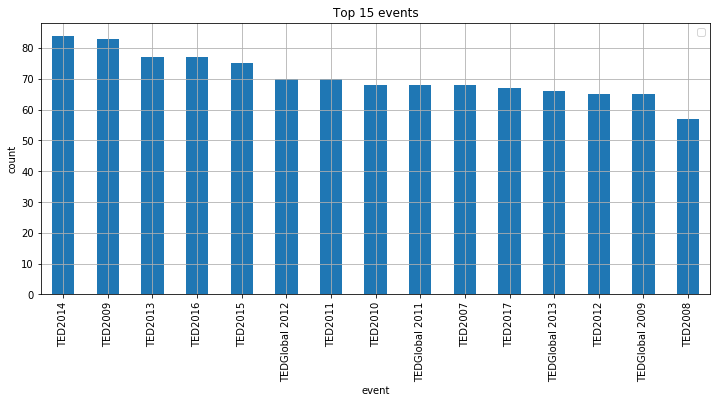

In [226]:
show_tops(main, 'event', 15)

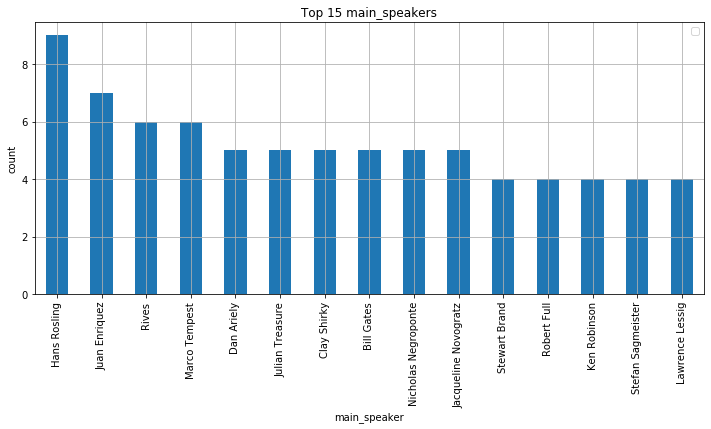

In [185]:
show_tops(main, 'main_speaker', 15)

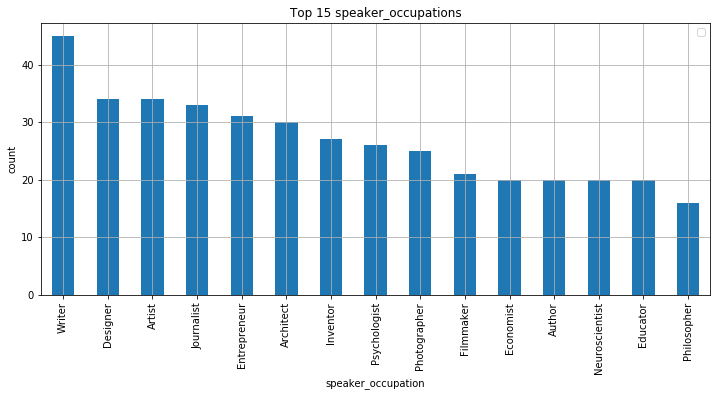

In [186]:
show_tops(main, 'speaker_occupation', 15)

Here another dataset is created consisting frequency of different tags used in talks.

In [221]:
tags = []
for i in range(2550):
    for j in range(len(main['tags'][i])):
        #print(str(i) + " - " + str(j))
        tags.append(main['tags'][i][j])
        #a = 1
counter=collections.Counter(tags)
tags_df = pd.Series(counter,index=counter.keys()).rename_axis('tags').reset_index(name='count')

This is a function for showing bar chart based on values of two features.

In [285]:
def show_bar(df, categorical_feature, numerical_feature, limit):
    #fig, ax = plt.subplots()
    df.sort_values(by=[numerical_feature], ascending=False)[0:limit].plot(kind='bar',x = categorical_feature, figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + categorical_feature + " by " + numerical_feature)
    plt.xlabel(categorical_feature)
    plt.ylabel(numerical_feature)
    plt.xticks(rotation='vertical')
    plt.legend([])
    plt.show()

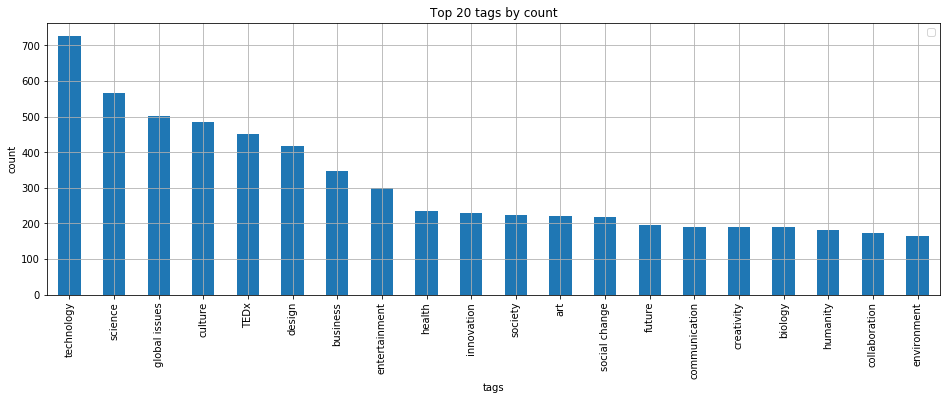

In [286]:
show_bar(tags_df, 'tags', 'count', 20)

Here another feature is created. published_date which is seconds is converted into timestamp and then year is extracted.

In [244]:
main['year'] = main['published_date'].apply(lambda x: pd.to_datetime(x, unit='s').year)

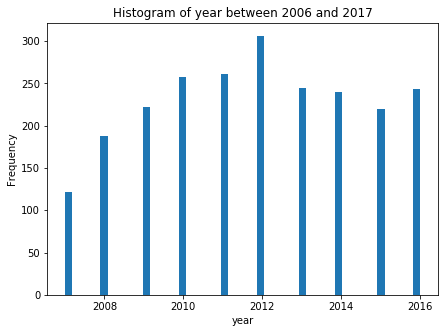

In [248]:
histogram(main, 'year', main['year'].min(), main['year'].max())

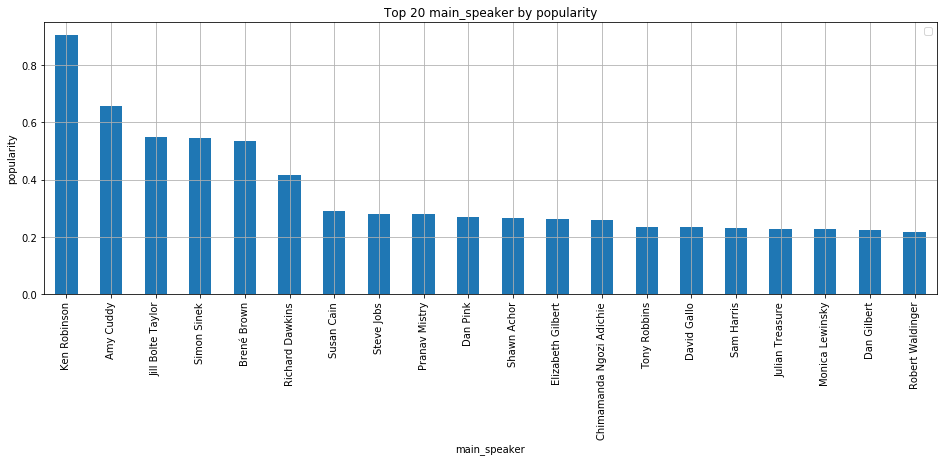

In [289]:
show_bar(main[['main_speaker','popularity']], 'main_speaker', 'popularity', 20)

This is a function for showing bar chart based on aggregation of one feature.

In [307]:
def show_bar_aggregate(dataset, feature1, feature2, aggregation, limit):
    df = pd.DataFrame([])
    if aggregation == 'mean':
        df = main.groupby([feature1])[feature2].mean().rename_axis(feature1).reset_index(name=aggregation)
    elif aggregation == 'min':
        df = main.groupby([feature1])[feature2].min().rename_axis(feature1).reset_index(name=aggregation)
    elif aggregation == 'max':
        df = main.groupby([feature1])[feature2].max().rename_axis(feature1).reset_index(name=aggregation)
    df.sort_values(by=[aggregation], ascending=False)[0:limit].plot(kind='bar',x = feature1, figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + feature1 + " by " + aggregation + " of " + feature2)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks(rotation='vertical')
    plt.legend([])
    plt.show()

This is a function for showing two bar charts next to eachother for comparison. 

In [372]:
def show_bar_agg_two_groups(dataset, feature1, feature2, feature3, aggregation, limit):
    df = pd.DataFrame([])
    if aggregation == 'mean':
        df = main.groupby([feature1])[feature2, feature3].mean().rename_axis(feature1).reset_index(feature1)
    elif aggregation == 'min':
        df = main.groupby([feature1])[feature2, feature3].min().rename_axis(feature1).reset_index(feature1)
    elif aggregation == 'max':
        df = main.groupby([feature1])[feature2, feature3].max().rename_axis(feature1).reset_index(feature1)
    df.sort_values(by=[feature2], ascending=False)[0:limit].plot(kind='bar',x = feature1,y=[feature2, feature3], figsize=(0.8*limit,5),rot=0, grid=True)
    plt.title("Top " + str(limit) + " " + feature1 + " by " + aggregation + " of " + feature2 + " and " + feature3)
    plt.xlabel(feature1)
    plt.ylabel(feature2 + " and " + feature3)
    plt.xticks(rotation='vertical')
    #plt.legend([])
    plt.show()

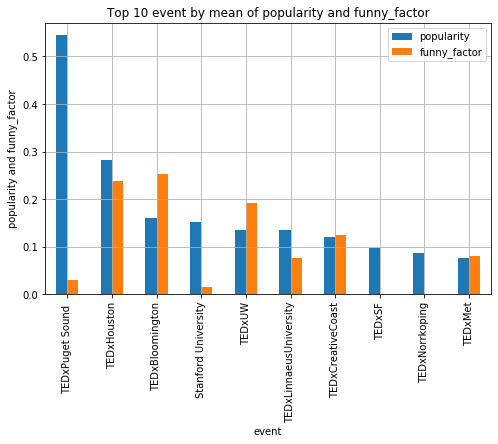

In [373]:
show_bar_agg_two_groups(main, 'event', 'popularity', 'funny_factor', 'mean', 10)

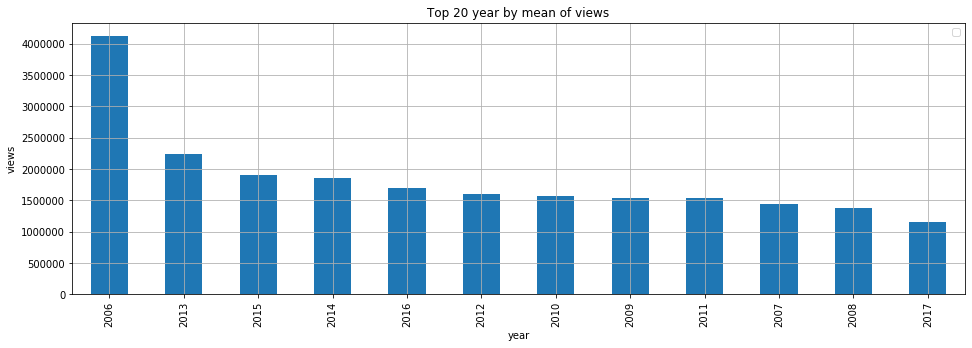

In [308]:
show_bar_aggregate(main, 'year', 'views', 'mean', 20)

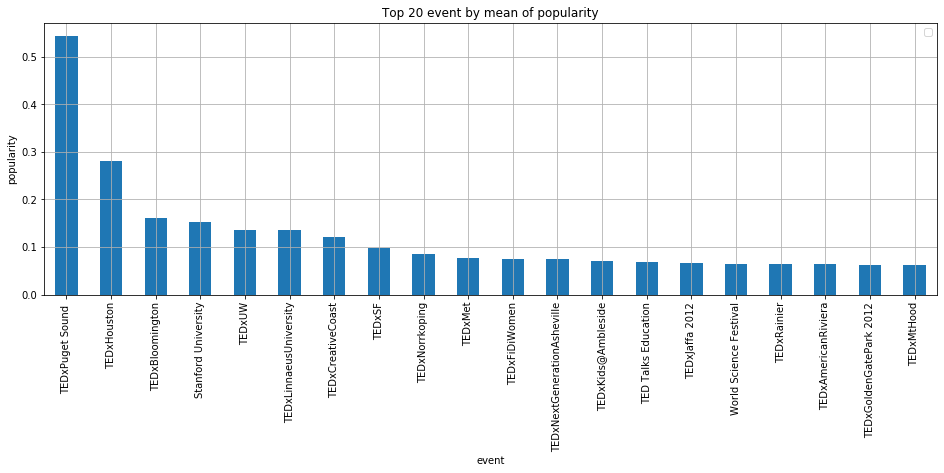

In [310]:
show_bar_aggregate(main, 'event', 'popularity', 'mean', 20)

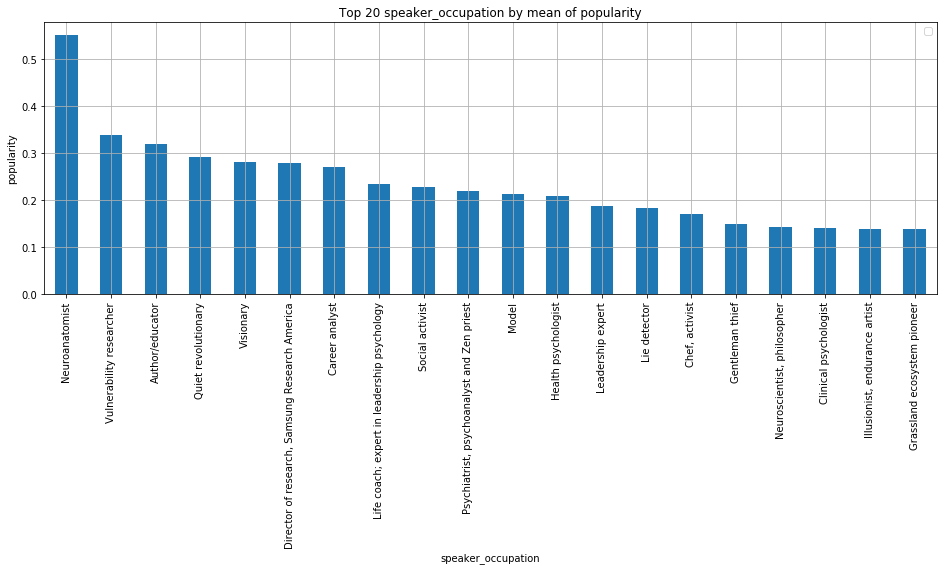

In [311]:
show_bar_aggregate(main, 'speaker_occupation', 'popularity', 'mean', 20)

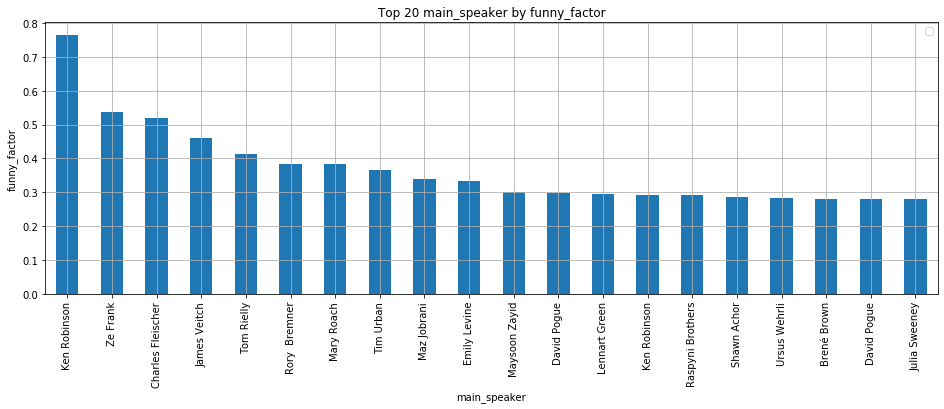

In [326]:
show_bar(main[['main_speaker','funny_factor']], 'main_speaker', 'funny_factor', 20)

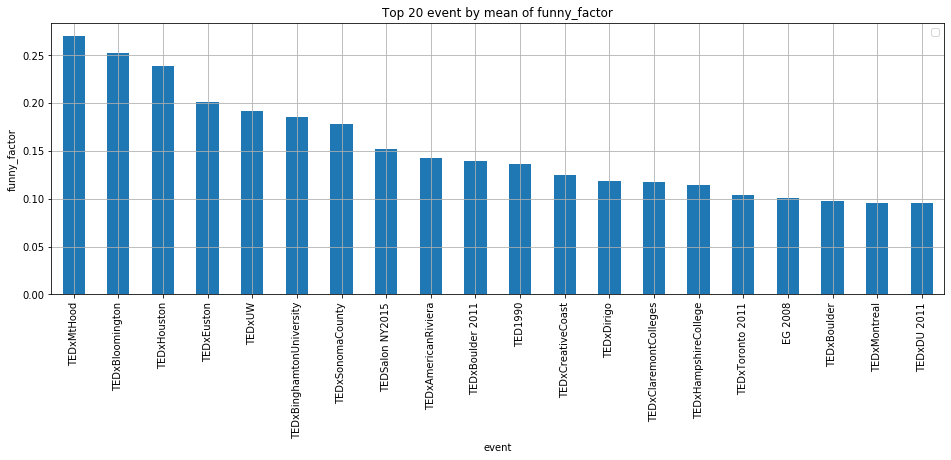

In [327]:
show_bar_aggregate(main, 'event', 'funny_factor', 'mean', 20)

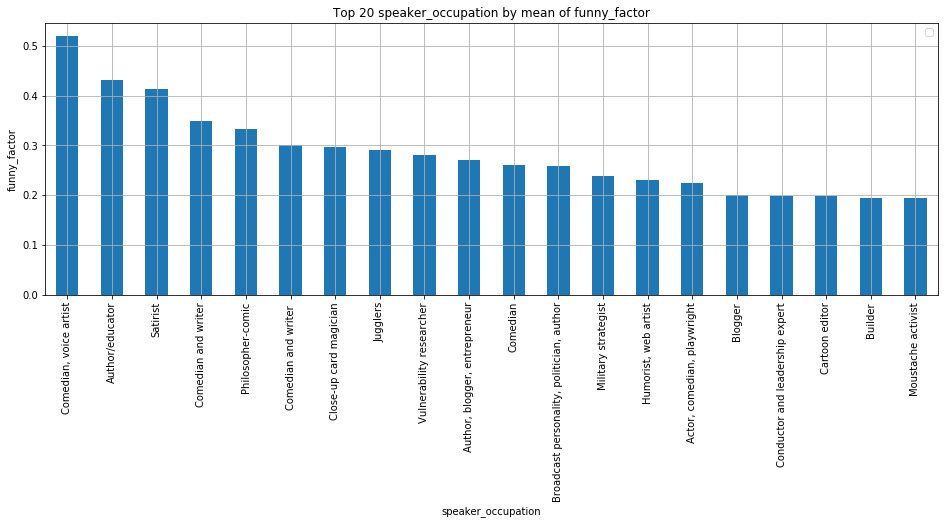

In [328]:
show_bar_aggregate(main, 'speaker_occupation', 'funny_factor', 'mean', 20)

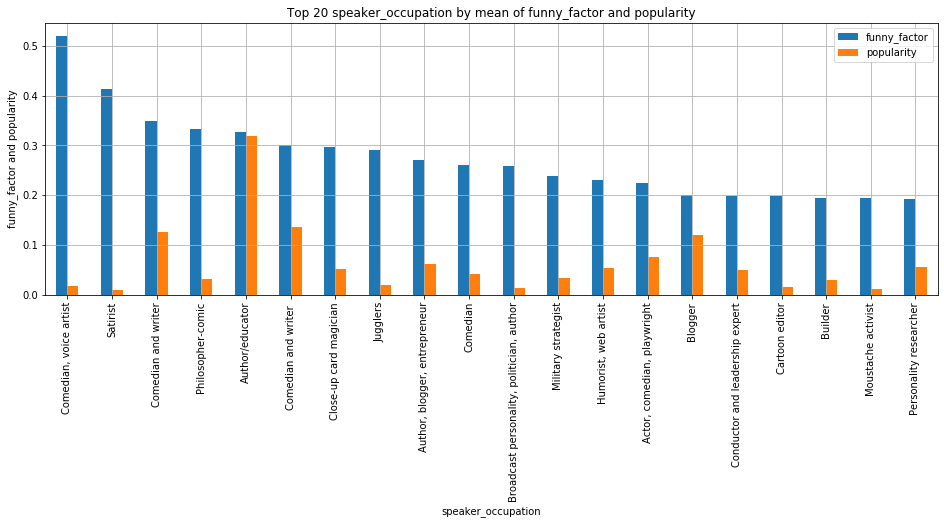

In [374]:
show_bar_agg_two_groups(main, 'speaker_occupation', 'funny_factor','popularity', 'mean', 20)